<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Привет! Спасибо, что вовремя сдала задание:) Ты проделала большую работу. Далее в файле мои комментарии ты сможешь найти в ячейках, аналогичных данной ( если рамки комментария зелёные - всё сделано правильно; жёлтые - есть замечания, но не критично; красные - нужно переделать). Не удаляй эти комментарии и постарайся учесть их в ходе выполнения проекта. 

</div>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
estate = pd.read_csv('real_estate_data.csv', sep='\t')
print(estate.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
print(estate.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

### Вывод

Файл с данными о продаже квартир состоит из 22 столбцов и 23 699 строк. Столбец first_day_exposition типа object, а должен быть типа datetime64. В 14 столбцах есть пустые значения. Для результатов анализа особенно важны значения столбцов: last_price, total_area, first_day_exposition и days_exposition, rooms, cityCenters_nearest, ceiling_height.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Данные загружены и изучены, класс

### Шаг 2. Предобработка данных

In [4]:
#преобразуем столбец first_day_exposition в в тип данных datetime64
estate['first_day_exposition'] = pd.to_datetime(estate['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [5]:
#проверка на наличие дубликатов
print(estate.duplicated().sum())

0


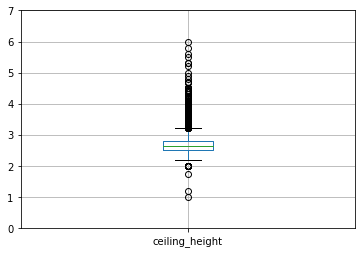

In [6]:
#посмотрим информацию о значениях в столбце ceiling_height
estate['ceiling_height'].describe()
plt.ylim(0, 7)
estate.boxplot(column='ceiling_height') #высота потолков более 5 м2 и менее 2м2 это уже выбросы

In [7]:
#заменим выброы в столбце ceiling_height на NaN
def estate_ceiling(ceiling_height):
    if ceiling_height > 2 and ceiling_height < 5:
        return ceiling_height
    else:
        return None
estate['ceiling_height'] = estate['ceiling_height'].apply(estate_ceiling)
estate['ceiling_height'].describe()

count    14453.000000
mean         2.725833
std          0.270519
min          2.200000
25%          2.520000
50%          2.650000
75%          2.800000
max          4.900000
Name: ceiling_height, dtype: float64

In [8]:
#восстановим пропущенные значения столбца living_area, путем вычитания kitchen_area из total_area
estate_living = estate['total_area'] - estate['kitchen_area']
estate['living_area'] = estate['living_area'].fillna(value=estate_living)

print(estate['living_area'].head(10))
print(estate['living_area'].isna().sum())

0    51.00
1    18.60
2    34.30
3      NaN
4    32.00
5    14.40
6    10.60
7    52.70
8    15.43
9    43.60
Name: living_area, dtype: float64
1464


In [9]:
#восстановим пропущенные значения столбца kitchen_area, путем вычитания living_area из total_are
estate_kitchen = estate['total_area'] - estate['living_area']
estate['kitchen_area'] = estate['kitchen_area'].fillna(value=estate_kitchen)

print(estate['kitchen_area'].head(10))
print(estate['kitchen_area'].isna().sum())

0    25.00
1    11.00
2     8.30
3      NaN
4    41.00
5     9.10
6    14.40
7    18.90
8     8.81
9     6.50
Name: kitchen_area, dtype: float64
1464


### Вывод

В столбце first_day_exposition нужно изменить данные на datetime64, потому что так находится информация о календарных днях.  
В столбце floors_total пропущено 0,36% значений, это очень мало, поэтому не будем их заполнять и оставим как есть.   
Дубликаты не обнаружены.   
В столбце ceiling_height очень много пропущенных значений, так как стоблец нам понадобится, заменим выбросы на NaN, чтобы не искажать будущие расчеты. Но не будем подставлять вместо NaN числовые значения, потому что у нас нет никакой зависимости для их расчета, а усреднение такого большого количества пропусков исказит результат. Возможно, причина незаполнения в том, что не все собственники при заполнении объявлений "держали в голове" информацию о высоте потолков.  
В столбцах: living_area и kitchen_area есть пропущенные значения, которые можно восстановить, так как у нас есть данны общей площади, а количество пропусков в этих столбцах разное, часть точно можно восстановить.



<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Вся требуемая предобработка выполнена, всё логично и точно, продолжай в том же духе!)


### Шаг 3. Посчитайте и добавьте в таблицу

In [10]:
#расчитаем цену квадратного метра
estate['m2_price'] = estate['last_price'] / estate['total_area']
print(estate['m2_price'].head())

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
Name: m2_price, dtype: float64


In [11]:
#добавим столбец с днем недели, месяцем и годом публикации
#округлим дату до ближайшего дня
estate['first_day_exposition'] = estate['first_day_exposition'].dt.round('1D')

#создадим столбец с днем недели 
estate['first_day_weekday'] = estate['first_day_exposition'].dt.weekday
print(estate['first_day_weekday'].head())

0    3
1    1
2    3
3    4
4    1
Name: first_day_weekday, dtype: int64


In [12]:
#создадим столбец с годом объявления
estate['first_day_year'] = estate['first_day_exposition'].dt.year
print(estate['first_day_year'].head())

0    2019
1    2018
2    2015
3    2015
4    2018
Name: first_day_year, dtype: int64


In [13]:
#создадим столбец с месяцем объявления
estate['first_day_month'] = estate['first_day_exposition'].dt.month
print(estate['first_day_month'].head())

0     3
1    12
2     8
3     7
4     6
Name: first_day_month, dtype: int64


In [14]:
#создадим столбец с классификатором этажности квартиры: первый, последний, другой
def floor_type(row):
    for i in range(len(row)):
        floor = row[8]
        floors_total = row[6]
        if floor == 1:
            return 'первый'
        if floor == floors_total:
            return 'последний'
        return 'другой'
estate['floor_type'] = estate.apply(floor_type, axis=1)

In [15]:
print(estate['floor_type'].value_counts())
print(estate['floor_type'].head(80))

другой       17446
последний     3336
первый        2917
Name: floor_type, dtype: int64
0        другой
1        первый
2        другой
3        другой
4        другой
        ...    
75       другой
76       первый
77       первый
78       другой
79    последний
Name: floor_type, Length: 80, dtype: object


In [16]:
#найдем отношение жилой площади к общей площади (living_area / total_area)
estate['living_to_total'] = estate['living_area'] / estate['total_area']
#найдем отношение площади кухни к общей площади
estate['kitchen_to_total'] = estate['kitchen_area'] / estate['total_area']


### Вывод
Для дальнейших расчетов и решения цели исследования были добавлены столбцы с информацией:  
- стоимость квадратного метра:  
- день недели, месяц и год публикации объявления;  
- классификатор этажности продаваемой квартиры (первый, последний этаж, либо другой);  
- отношение жилой площади и площади кухни к общей площади продаваемой квартиры.


<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Всё посчитано верно и добавлено в таблицу, продолжай в том же духе)

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

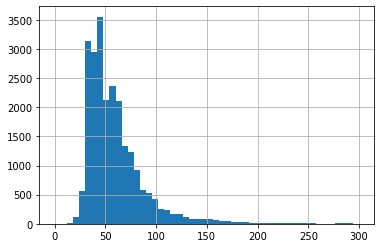

In [17]:
#построим гистограммы для анализа данных по параметрам: площадь, цена, число комнат, высота потолков квартир
estate['total_area'].hist(bins=50, range=(0, 300))
plt.show()

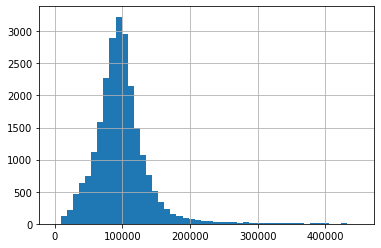

In [18]:
estate['m2_price'].hist(bins=50, range=(0, 450000))
plt.show()

(0, 250000)

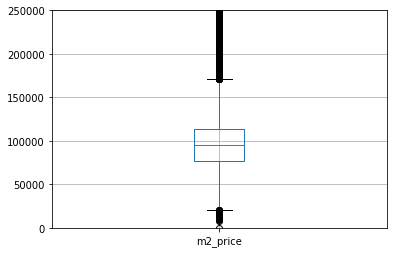

In [19]:
estate.boxplot(column='m2_price')
plt.ylim(0, 250000)

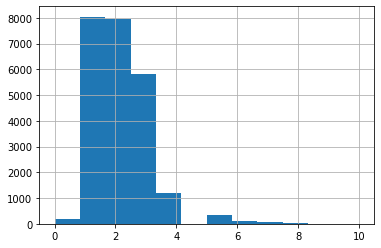

In [20]:
estate['rooms'].hist(bins=12, range=(0, 10))
plt.show()

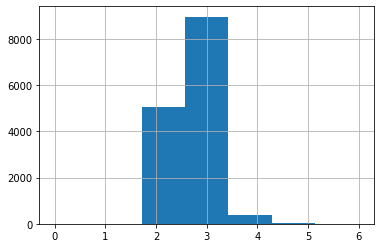

In [21]:
estate['ceiling_height'].hist(bins=7, range=(0, 6))
plt.show()

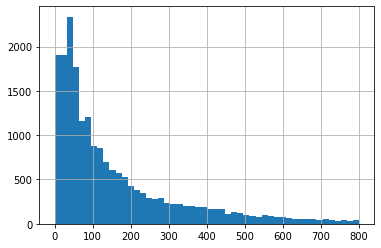

In [22]:
#построим гистограмму по времени продажи квартир days_exposition
estate['days_exposition'].hist(bins=50, range=(0, 800))
plt.show()

In [23]:
print('Среднее время продажи квартиры: {:.0f} день'.format(estate['days_exposition'].mean()))
print('Медианное время продажи квартиры: {:.0f} дней'.format(estate['days_exposition'].median()))

Среднее время продажи квартиры: 181 день
Медианное время продажи квартиры: 95 дней


In [24]:
estate['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

(0, 550)

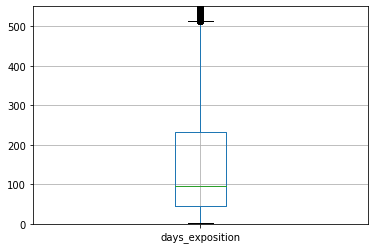

In [25]:
#построим диаграмму размаха дней продажи квартиры
estate.boxplot(column='days_exposition')
plt.ylim(0, 550)

In [26]:
#Уберите редкие (длительность продажи 42-60 дней) и выбивающиеся значения (длительность продажи более 600 дней)
normal_exposition = estate[
    (estate['days_exposition'] < 600) & ~ 
    ((estate['days_exposition'] <=60) & (estate['days_exposition'] >=42))
]

In [27]:
#анализ данных по выборке abnormal_exposition
normal_exposition['days_exposition'].describe()

count    16421.000000
mean       154.692954
std        142.827495
min          1.000000
25%         35.000000
50%        111.000000
75%        223.000000
max        599.000000
Name: days_exposition, dtype: float64

(0, 550)

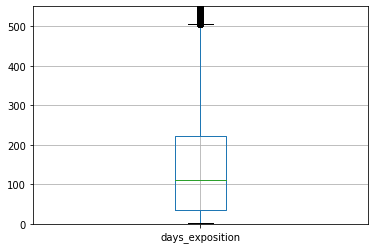

In [28]:
normal_exposition.boxplot(column='days_exposition')
plt.ylim(0, 550)

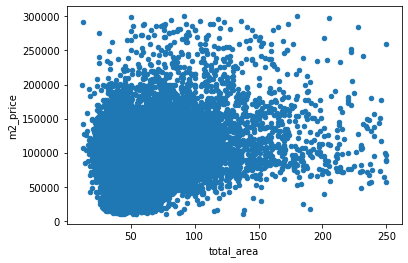

In [29]:
#проверим зависимость цены от площади квартиры, исключив выбивающиеся значения площади, ограничив дипазон 10-300 м2,
#а цену за 1 м2 диапазоном от 30 000 - 250 000 р./м2
normal_total_area = estate.query('(10000 <= m2_price <= 300000) and (10 <= total_area <= 250)')
normal_total_area.plot(x='total_area', y='m2_price', kind='scatter')

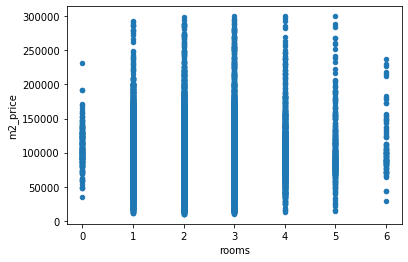

In [30]:
#проверим зависимость цены от числа комнат, исключив выбивающиеся значения, ограничив дипазон 0-6 комнаты
normal_rooms = estate.query('(10000 <= m2_price <= 300000) and (0 <= rooms <= 6)')
normal_rooms.plot(x='rooms', y='m2_price', kind='scatter')

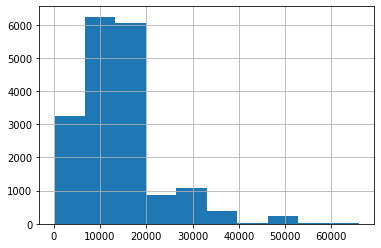

In [31]:
#построим гистограмму удаленности от центра 
estate['cityCenters_nearest'].describe()
estate['cityCenters_nearest'].hist()
plt.show()

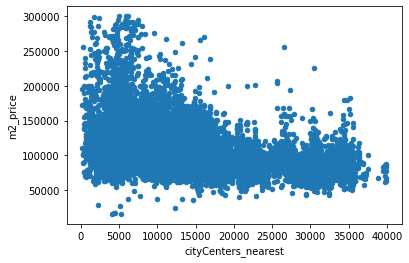

In [32]:
#проверим зависимость цены от удаленности от центра исключив выбивающиеся значения, ограничив дипазон 0-40 000 км от центра
normal_centers_nearest = estate.query('(10000 <= m2_price <= 300000) and (0 <= cityCenters_nearest <= 40000)')
normal_centers_nearest.plot(x='cityCenters_nearest', y='m2_price', kind='scatter')
plt.show()

<div style="border:solid  orange  2px; padding: 20px"> <h1 style="color: orange ; margin-bottom:20px">Комментарий наставника</h1>

Хорошо, но очень мало выводов в работе

In [33]:
#найдем 10 населенных пунктов с наибольшим количеством объявлений
ad_locality_max = estate['locality_name'].value_counts()
ad_locality_max = ad_locality_max.head(10)
print(ad_locality_max)
#создадим список из населенных пунктов с наибольшим количеством объявлений
locality_data = ['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 
                 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']
print(locality_data)

Санкт-Петербург      15721
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64
['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']


In [34]:
#вычислим среднюю цену квадратного метра в населённых пунктах c наибольшим числом объявлений
price_locality = estate.query('locality_name in @locality_data')
price_locality = price_locality.pivot_table(index='locality_name', values='m2_price', aggfunc='median')
price_locality.sort_values(by='m2_price', ascending=False)

,m2_price
locality_name,
Санкт-Петербург,104761.904762
Пушкин,100000.000000
деревня Кудрово,91860.465116
посёлок Парголово,91642.857143
посёлок Мурино,85878.462169
посёлок Шушары,76876.172608
Колпино,74723.748474
Гатчина,67796.610169
Всеволожск,65789.473684


In [35]:
#выборка по городу Санкт-Петербург
locality_Petersburg = estate.query('locality_name == "Санкт-Петербург"')
print(locality_Petersburg['cityCenters_nearest'].head(10))

0     16028.0
2     13933.0
3      6800.0
4      8098.0
7     11634.0
9     15008.0
10    13878.0
15    14259.0
16    10698.0
17    14616.0
Name: cityCenters_nearest, dtype: float64


In [36]:
# удалим пропущенные значения в столбце cityCenters_nearest DF locality_Petersburg для дальнейших расчетов
locality_Petersburg['cityCenters_nearest'].isna().sum()
locality_Petersburg.dropna(subset = ['cityCenters_nearest'], inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
#расстояние до центра в км
locality_Petersburg['cityCenters_km'] = locality_Petersburg['cityCenters_nearest'] / 1000
locality_Petersburg['cityCenters_km'] = locality_Petersburg['cityCenters_km'].astype('int')
locality_Petersburg['cityCenters_km']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0        16
2        13
3         6
4         8
7        11
         ..
23689    16
23690     6
23691     4
23694     4
23697    10
Name: cityCenters_km, Length: 15660, dtype: int64

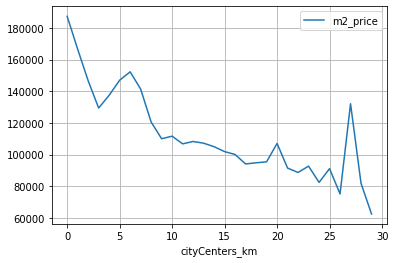

In [38]:
#посчитаем среднюю цену по километрам locality_Petersburg['price_m2_km'] или укрупняем группы?
locality_Petersburg.pivot_table(index='cityCenters_km', values='m2_price').plot(grid=True)

In [39]:
#выделим квартиры в центре, удаленность от центра до 7 км
Petersburg_centre = locality_Petersburg.query('cityCenters_km <= 7')

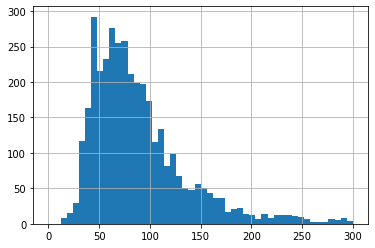

In [40]:
#гистограмма распределения площади квартир в центральном районе Санкт-Петербурга
Petersburg_centre['total_area'].hist(bins=50, range=(0, 300))
plt.show()

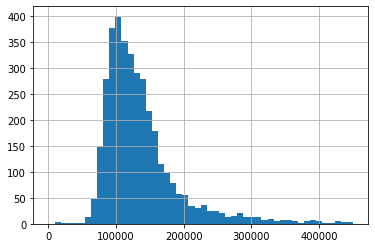

In [41]:
Petersburg_centre['m2_price'].hist(bins=50, range=(0, 450000))
plt.show()

(0, 400000)

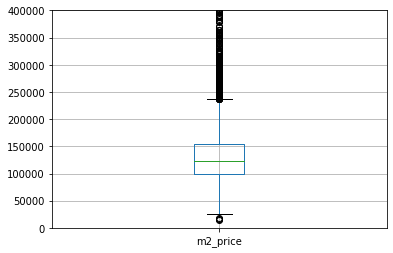

In [42]:
Petersburg_centre.boxplot(column='m2_price')
plt.ylim(0, 400000)

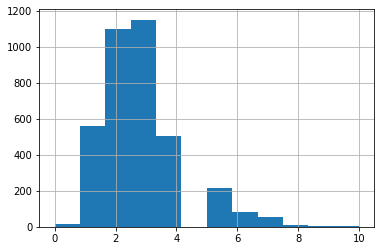

In [43]:
Petersburg_centre['rooms'].hist(bins=12, range=(0, 10))
plt.show()

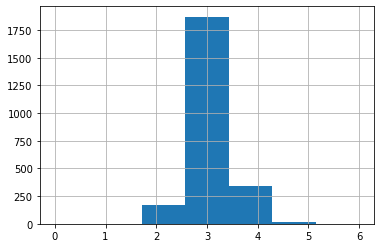

In [44]:
Petersburg_centre['ceiling_height'].hist(bins=7, range=(0, 6))
plt.show()

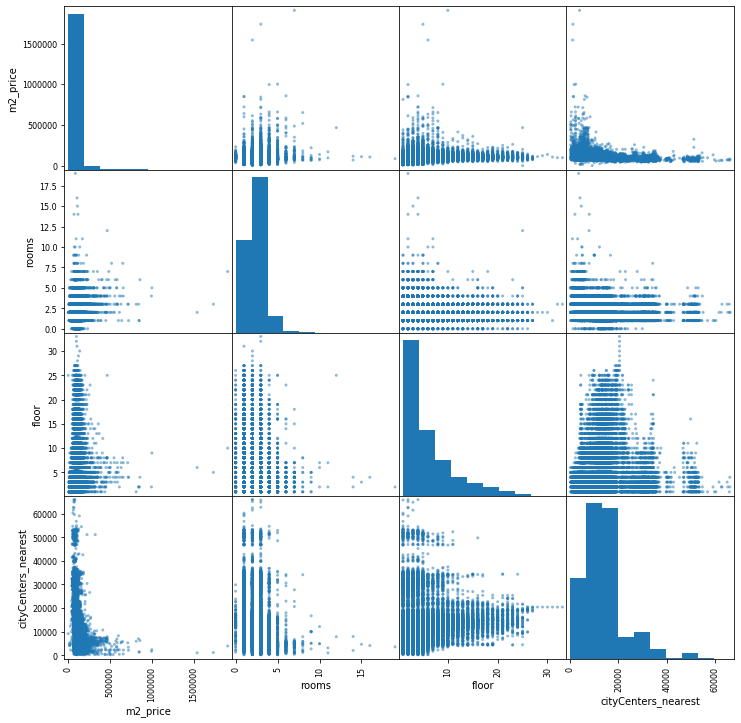

In [45]:
#диаграммы рассеяния зависимости стоимости квартиры от числа комнат, этажа, удаленности от центра
#для данных по всему городу
all_state = estate.loc[:, ['m2_price', 'rooms', 'floor', 'cityCenters_nearest']]
pd.plotting.scatter_matrix(all_state, figsize=(12, 12))
plt.show()

In [46]:
#для всех пар зависимостей найдем коэффициент корреляции
#для данных по всему городу
all_state.corr()

,m2_price,rooms,floor,cityCenters_nearest
m2_price,1.000000,0.055420,0.129068,-0.317951
rooms,0.055420,1.000000,-0.150862,-0.184864
floor,0.129068,-0.150862,1.000000,0.009084
cityCenters_nearest,-0.317951,-0.184864,0.009084,1.000000


In [47]:
#зависимость цены от даты размещения объявления
all_state_day = estate.loc[:, ['m2_price', 'first_day_weekday', 'first_day_month', 'first_day_year']]
all_state_day.corr()

,m2_price,first_day_weekday,first_day_month,first_day_year
m2_price,1.000000,-0.007272,-0.001995,0.008516
first_day_weekday,-0.007272,1.000000,0.011496,-0.004799
first_day_month,-0.001995,0.011496,1.000000,-0.269642
first_day_year,0.008516,-0.004799,-0.269642,1.000000


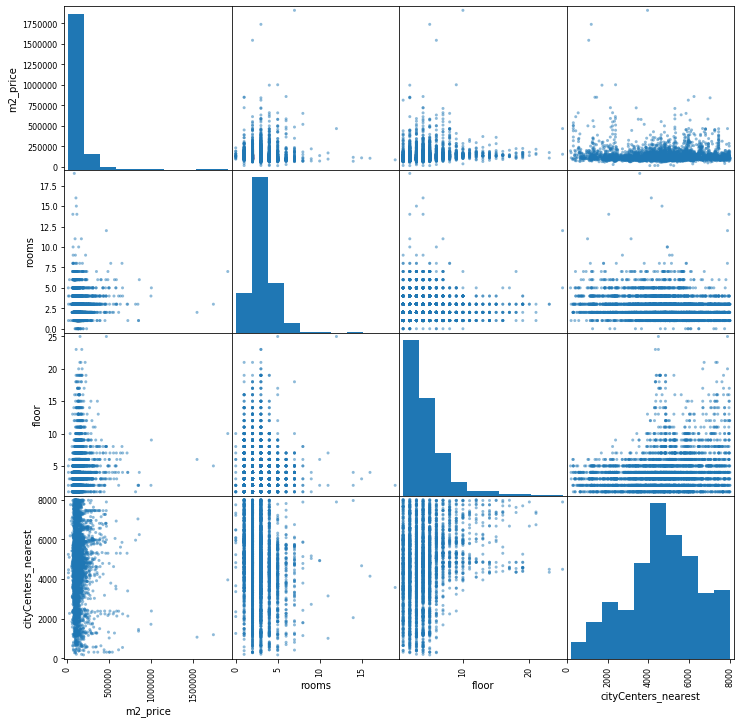

In [48]:
#диаграммы рассеяния зависимости стоимости квартиры от числа комнат, этажа, удаленности от центра
#для данных по центру Санкт-Петербурга
Peterburg_state = Petersburg_centre.loc[:, ['m2_price', 'rooms', 'floor', 'cityCenters_nearest']]
pd.plotting.scatter_matrix(Peterburg_state, figsize=(12, 12))
plt.show()

In [49]:
#для всех пар зависимостей найдем коэффициент корреляции
#для данных по центру Санкт-Петербурга
Peterburg_state.corr()

,m2_price,rooms,floor,cityCenters_nearest
m2_price,1.000000,0.006247,0.123955,-0.030939
rooms,0.006247,1.000000,-0.038924,-0.176458
floor,0.123955,-0.038924,1.000000,0.249451
cityCenters_nearest,-0.030939,-0.176458,0.249451,1.000000


In [50]:
Peterburg_state_day = Petersburg_centre.loc[:, ['m2_price', 'first_day_weekday', 'first_day_month', 'first_day_year']]
Peterburg_state_day.corr()

,m2_price,first_day_weekday,first_day_month,first_day_year
m2_price,1.000000,0.015259,-0.015750,0.007816
first_day_weekday,0.015259,1.000000,0.026008,0.001477
first_day_month,-0.015750,0.026008,1.000000,-0.241754
first_day_year,0.007816,0.001477,-0.241754,1.000000


### Вывод


Проанализировав гистограммы площади и цены, можно сделать вывод о том, что распределение этих величин нельзя считать нормальным, так как данные распределены не равномерно. Наиболее часто встречающаяся площадь продаваемых квартир находится в диапазоне 30 - 40 м2, стоимостью около 0,4 млн. руб., и чаще всего квартира с одной комнатой и высотой потолка около 2,5 м2.   

Анализ количества дней продажи квартиры показывает, что чаще всего квартиры находятся в продаже 1-200 дней, оптимальным считается период продажи около 3 месяцев. А если квартира продается более 500 дней, это уже аномалия. По результатам анализа также видно, что нет минимально допустимого срока, необходимого для продажи, так как очень много продаж, или снятия объявлений происходит в рамках всего нескольких дней. На гистограмме еще наблюдается некоторый всплеск снятия объявлений через примерно 1.5 месяца, нельзя точно сказать с чем это может быть связанно, субъективно можно предположить, что объявления просто снимаются по результатам месяца с продажи, возможно покупатели хотят посмотреть реакцию рынка, но отказываются в итоге от продажи.  
Еще можно отметить, что среднее почти в 2 раза больше медианы, значит разброс значений очень высокий.   
Проанализировав данные без редких и выбивающихся значений (значения более 600 дней продажи считаем редкими, так как на гистограмме видно, что они встречаются уже очень редко, а значения в диапазоне 42-60 дней выбивающимися), сделали вывод о том, что хотя стандартное отклонение и уменьшилось 78 единиц и стало ближе к единице, общие параметры выборки не изменились, то есть средний срок продажи квартиры все равно составляет примерно 3 месяца.  

Проанализировали зависимость цены 1 м2 квартиры от факторов: площадь, количество комнат, удаленность от центра. По результатам делаем вывод, что удаленность от центра города сильно влияет на стоимость 1м2 квартиры, а вот площадь и количество комнат особенно сильного влияния не оказывают.

Самая дорогая недвижимость распроложена в Санкт-Петербурге. При этом удаленность от центра напрямую влияет на стоимость квартир. Центр города, судя по изменению цены, имеет диаметр около 14 км. Но на графике также видно, что увеличение стоимости происходит на расстоянии 22 км от центра, возможно это связано с тем, что город имеет не форму окружности, а огибает Финский залив, и где-то на расстоянии 22 км от центра расположен респектабельный район с высокими ценами на квартиры.

Если сравнить квартиры в центре Санкт-Петербурга с общей выборкой, по показателям: площадь, цена, число комнат, высота потолков, можно сделать выводы: в центре средняя площадь продаваемых квартир выше, цена выше (в общей выборке цена средняя до 1 млн. руб., а в центре выше 1 млн. руб), среднее количество комнат в центральных квартирах выше, чем в общей выборке (3 комнаты против 2).  

Постоили диаграммы рассеяния зависимости стоимости квартиры от числа комнат, этажа, удаленности от центра и даты размещения объявления по 2 выборкам: по всему городу и по центру Санкт-Петербурга. На основе полученных данных сделаем выводы:  
- в целом по городу цена больше всего зависит от этажа, а в центре города от близости к центру;
- зависимость от этажа квартиры есть и в обоих выборках она практически одинаковая;
- от количества комнат цена не зависит;
- от даты объявления цена не зависит, но в центре корреляция с днем недели и месяцем немного выше, чем в целом по городу.

<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

Просто класс! Очень здорово и детально, работа проделана колоссальная, продолжай в том же духе


### Шаг 5. Общий вывод

Параметры ценообразования на квартиры в городе Санкт-Петербург и в частности в его центральной части:  
- оптимальный период продажи составляет 3 месяца и не более 200 дней;
- удаленность от центра напрямую влияет на стоимость м2;
- площадь, количество комнат, дата объявления на стоиомость квартиры не влияют;
- на стоимость квартиры оказывает сильное влияние этаж, в общем по городу это влияние сильнее, чем удаленность от центра;
- средняя цена за 1 м2 в целом по городу составляет 90 тыс.руб., а в центральной части 110 тыс. руб.
- минимальная цена за 1 м2 в целом по городу, в том числе в центральной части составляет 25 000 руб.;
- максимально оптимальная цена за 1 м2 в целом по городу составляет 170 000 руб., а в центральной части 230 000 руб.;
- минимальная высота потолков в квартиру 1,9 м2, а наиболее часто встречающаяся 2,5 м2;
- чаще всего в продаже 1 комнатные квартиры, площадью 35-40 м2, а в центральной части чаще продают квартиры с бОльшей площадью, чем в целом по городу.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Замечательный вывод покрывающий все аспекты проделанной работы! 

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод

<div style="border:solid  green  2px; padding: 20px">

<h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

#### Код

Всё отлично. Из того, что очень порадовало - соблюдена структура проекта, шаги из задания обозначены и выполнены последовательно, код написан аккуратно, используются комментарии к коду, быстро можно понять, какие операции выполняют сложные конструкции. В качестве совета предлагаю глубже изучить библиотеку Seaborn для построения более ярких и качественных визуализаций в Python, так как иногда хорошая красочная визуализация может сказать очень многое о данных.

#### Выводы

Ты пишешь отличные обоснованные выводы по проделанной раблоте и выдвигаешь корректные гипотезы - это очень радует!) Так же видно глубокое понимание проведённого анализа. Было очень интересно проверять твой проект и следить за твоей мыслью, продолжай в том же духе) Удачи!)